# **Task 1: Petition Topic Classification**

## **Import necessary libraries**

In [1]:
# Import libraries
!pip install nltk
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.stats import uniform, loguniform

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## **Data loading and Exploration**

In [2]:
# Load dataset
df = pd.read_csv('/content/comp1804_coursework_dataset_24-25.csv')

# Explore dataset
print(f"Dataset inforamtion: {df.info()}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   petition_ID               8898 non-null   int64  
 1   has_entity                8898 non-null   object 
 2   relevant_department       7099 non-null   object 
 3   deviation_across_regions  7321 non-null   float64
 4   petition_status           8898 non-null   object 
 5   petition_topic            8867 non-null   object 
 6   petition_importance       20 non-null     object 
 7   petition_text             8896 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 556.3+ KB
Dataset inforamtion: None

Dataset shape: (8898, 8)

Column names: Index(['petition_ID', 'has_entity', 'relevant_department',
       'deviation_across_regions', 'petition_status', 'petition_topic',
       'petition_importance', 'petition_text'],
      dtype='object')


In [13]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
petition_ID                    0
has_entity                     0
relevant_department         1799
deviation_across_regions    1577
petition_status                0
petition_topic                31
petition_importance         8878
petition_text                  2
text_length                    0
dtype: int64


Petition Topic Class distribution:

petition_topic
environment and animal welfare    0.269426
health and social care            0.239991
economy, labour and welfare       0.138942
education                         0.136123
culture, sport and media          0.119770
uk government and devolution      0.083568
london                            0.006879
Health And Social Care            0.001692
Environment And Animal Welfare    0.001466
Economy, Labour And Welfare       0.000677
Culture, Sport And Media          0.000564
Education                         0.000564
Uk Government And Devolution      0.000226
London                            0.000113
Name: proportion, dtype: float64

 Number of Topics is 14

 Duplicate petition topics found!



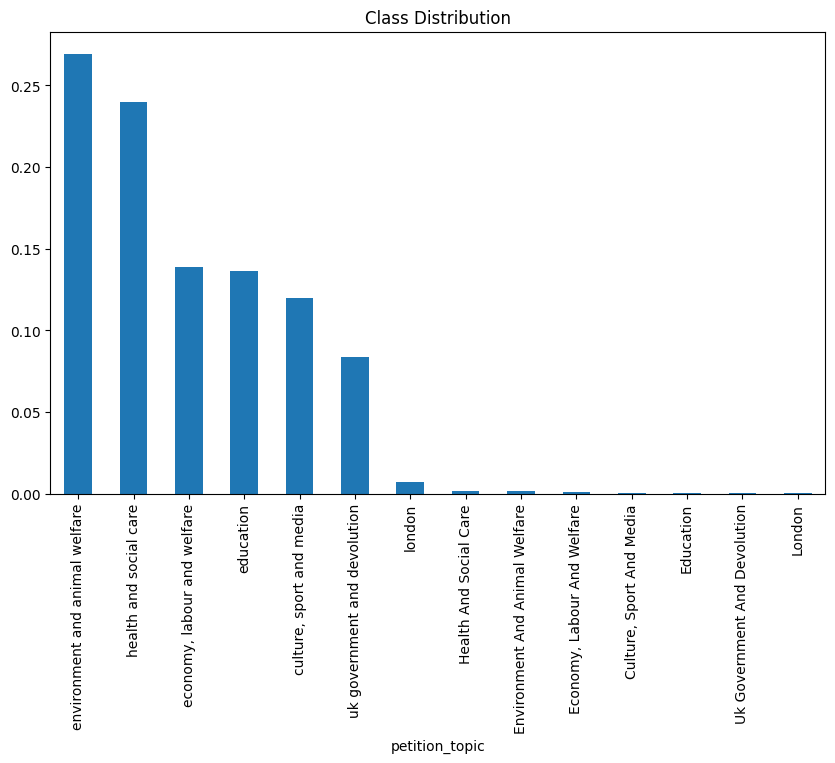

In [10]:
# Check petition_topic class distribution
print(f"Petition Topic Class distribution:\n")
print(df['petition_topic'].value_counts(normalize=True))
print(f"\n Number of Topics is {df['petition_topic'].nunique()}")

print(f"\n Duplicate petition topics found!\n")

# Visualise class distribution
plt.figure(figsize=(10,6))
df['petition_topic'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Distribution')
plt.show()

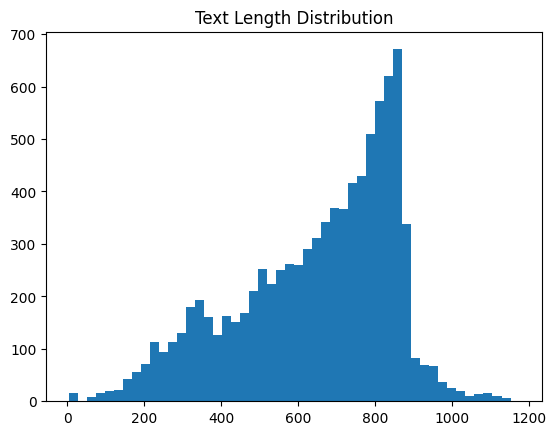

In [11]:
# Check text length distribution
df['text_length'] = df['petition_text'].astype(str).apply(len)
plt.hist(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.show()

## **Data Cleaning**

In [14]:
# Text cleaning function
def advanced_clean_text(text):
    if not isinstance(text, str):
        return ''

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply advanced text cleaning
df['cleaned_text'] = df['petition_text'].fillna('').apply(advanced_clean_text)

# Convert petition topics to lowercase
df['petition_topic'] = df['petition_topic'].str.lower()

# Drop rows with NaN values in the target variable
df = df.dropna(subset=['petition_topic'])

Number of Topics in 'petition_topic' column is 7



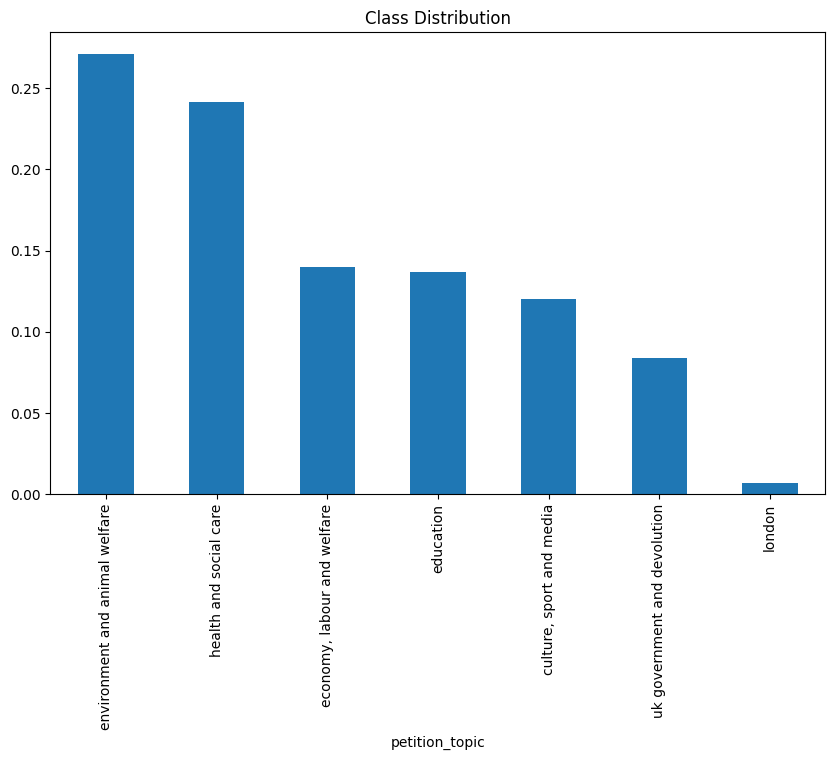

Refined Petition Topic Proportion:
petition_topic
environment and animal welfare    0.270892
health and social care            0.241683
economy, labour and welfare       0.139619
education                         0.136687
culture, sport and media          0.120334
uk government and devolution      0.083794
london                            0.006992
Name: proportion, dtype: float64

---------------------------------
Refined Petition Topic Count:
petition_topic
environment and animal welfare    2402
health and social care            2143
economy, labour and welfare       1238
education                         1212
culture, sport and media          1067
uk government and devolution       743
london                              62
Name: count, dtype: int64

---------------------------------
Sum of Refined Petition Topic Proportion: 1.0


In [15]:
print(f"Number of Topics in 'petition_topic' column is {df['petition_topic'].nunique()}\n")

# Visualise class distribution
plt.figure(figsize=(10,6))
df['petition_topic'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Distribution')
plt.show()

# Confirming data cleaning worked
print("Refined Petition Topic Proportion:")
print(df['petition_topic'].value_counts(normalize=True))
print("\n---------------------------------")
print("Refined Petition Topic Count:")
print(df['petition_topic'].value_counts())
print("\n---------------------------------")
print(f"Sum of Refined Petition Topic Proportion: {df['petition_topic'].value_counts(normalize=True).sum()}")

## **Feature engineering and Encoding**

In [16]:
# Feature Engineering

# Process has_entity features
entity_cols = ['EVENT', 'DATE', 'PERSON']
split_df = df['has_entity'].str.split('_', expand=True)

# Pad with None if fewer than 3 columns
split_df = split_df.reindex(columns=range(3), fill_value=None)

# Rename columns
split_df.columns = entity_cols

# Replace YES/NO with 1/0
split_df = split_df.replace({'YES': 1, 'NO': 0})

# Assign to DataFrame
df[entity_cols] = split_df

In [17]:
# Dataset Preparation

class PetitionDataset(Dataset):
    def __init__(self, texts, entities, labels, tokenizer, max_len):
        self.texts = texts
        self.entities = entities
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        entities = self.entities[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Update the conversion for assurance
        entities_num = [1 if x == 'YES' or x == 1 else 0 for x in entities]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'entities': torch.tensor(entities_num, dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## **Model building**

In [18]:
# Define Model
class TopicClassifier(torch.nn.Module):
    def __init__(self, n_classes, n_entities=3):
        super(TopicClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.entity_layer = torch.nn.Linear(n_entities, 32)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size + 32, n_classes)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, entities):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]

        entity_output = torch.nn.functional.relu(self.entity_layer(entities))
        combined = torch.cat((bert_output, entity_output), dim=1)
        return self.classifier(self.dropout(combined))

In [ ]:
# Training Setup

# Parameters
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
N_SPLITS = 5

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Convert labels to numeric values
label_map = {label: idx for idx, label in enumerate(df['petition_topic'].unique())}
df['label'] = df['petition_topic'].map(label_map)

# Cross-validation setup
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

best_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['label'])):
    print(f"\nFold {fold + 1}/{N_SPLITS}")

    # Train-validation split
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    # Handle class imbalance
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_df['label']),
        y=train_df['label']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Create datasets
    train_dataset = PetitionDataset(
        train_df['cleaned_text'].values,
        train_df[entity_cols].values,
        train_df['label'].values,
        tokenizer,
        MAX_LEN
    )

    val_dataset = PetitionDataset(
        val_df['cleaned_text'].values,
        val_df[entity_cols].values,
        val_df['label'].values,
        tokenizer,
        MAX_LEN
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize model
    model = TopicClassifier(n_classes=len(label_map)).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Training Loop
    print('Training...')
    # Store metrics for analysis
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            entities = batch['entities'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, entities)

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)

        # Store train metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Loop
        print('Validating...')
        model.eval()
        val_preds = []
        val_labels = []
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                entities = batch['entities'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, entities)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')


        # Overfitting Check
        print('Checking for overfitting...')
        if train_acc - val_accuracy > 0.1:
          print("Warning: Possible overfitting detected! 🚨")
        else:
          print("No signs of overfitting. ✅")

        # Save best model
        print('Saving best model...')
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
            print('Best model saved!')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


Fold 1/5


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Validating...
Val Loss: 0.3608 | Val Accuracy: 0.8929
Epoch 1/3
Train Loss: 0.6079 | Train Accuracy: 0.8195
Val Loss: 0.3608 | Val Accuracy: 0.8929
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Best model saved!
Validating...
Val Loss: 0.3850 | Val Accuracy: 0.9087
Epoch 2/3
Train Loss: 0.2328 | Train Accuracy: 0.9294
Val Loss: 0.3850 | Val Accuracy: 0.9087
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Best model saved!
Validating...
Val Loss: 0.4573 | Val Accuracy: 0.9126
Epoch 3/3
Train Loss: 0.1079 | Train Accuracy: 0.9676
Val Loss: 0.4573 | Val Accuracy: 0.9126
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Best model saved!

Fold 2/5


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Validating...
Val Loss: 0.4078 | Val Accuracy: 0.8749
Epoch 1/3
Train Loss: 0.6762 | Train Accuracy: 0.7952
Val Loss: 0.4078 | Val Accuracy: 0.8749
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.3729 | Val Accuracy: 0.8878
Epoch 2/3
Train Loss: 0.2584 | Train Accuracy: 0.9275
Val Loss: 0.3729 | Val Accuracy: 0.8878
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.4733 | Val Accuracy: 0.9014
Epoch 3/3
Train Loss: 0.1422 | Train Accuracy: 0.9602
Val Loss: 0.4733 | Val Accuracy: 0.9014
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...

Fold 3/5


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Validating...
Val Loss: 0.3788 | Val Accuracy: 0.8968
Epoch 1/3
Train Loss: 0.6075 | Train Accuracy: 0.8169
Val Loss: 0.3788 | Val Accuracy: 0.8968
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.4245 | Val Accuracy: 0.9075
Epoch 2/3
Train Loss: 0.2468 | Train Accuracy: 0.9267
Val Loss: 0.4245 | Val Accuracy: 0.9075
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.4489 | Val Accuracy: 0.9092
Epoch 3/3
Train Loss: 0.1256 | Train Accuracy: 0.9622
Val Loss: 0.4489 | Val Accuracy: 0.9092
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...

Fold 4/5


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Validating...
Val Loss: 0.4365 | Val Accuracy: 0.8787
Epoch 1/3
Train Loss: 0.6030 | Train Accuracy: 0.8129
Val Loss: 0.4365 | Val Accuracy: 0.8787
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.4638 | Val Accuracy: 0.8883
Epoch 2/3
Train Loss: 0.2307 | Train Accuracy: 0.9285
Val Loss: 0.4638 | Val Accuracy: 0.8883
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.5292 | Val Accuracy: 0.8934
Epoch 3/3
Train Loss: 0.1109 | Train Accuracy: 0.9646
Val Loss: 0.5292 | Val Accuracy: 0.8934
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...

Fold 5/5


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Validating...
Val Loss: 0.4534 | Val Accuracy: 0.8754
Epoch 1/3
Train Loss: 0.6241 | Train Accuracy: 0.8144
Val Loss: 0.4534 | Val Accuracy: 0.8754
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.3941 | Val Accuracy: 0.8911
Epoch 2/3
Train Loss: 0.2588 | Train Accuracy: 0.9257
Val Loss: 0.3941 | Val Accuracy: 0.8911
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...
Validating...
Val Loss: 0.4326 | Val Accuracy: 0.9019
Epoch 3/3
Train Loss: 0.1350 | Train Accuracy: 0.9590
Val Loss: 0.4326 | Val Accuracy: 0.9019
Checking for overfitting...
No signs of overfitting. ✅
Saving best model...


## **Model evaluation**

In [20]:
# Evaluation & Reporting

# Load best model
print('Loading best model...')
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
print('Best model loaded!')

# Generate predictions
print('Generating predictions...')
final_preds = []
true_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        entities = batch['entities'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, entities)
        preds = torch.argmax(outputs, dim=1)
        final_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
print('Predictions generated!')

# Generate metrics
print(f'\nFinal Test Accuracy: {accuracy_score(true_labels, final_preds):.2f}')

Loading best model...
Best model loaded!
Generating predictions...
Predictions generated!

Final Test Accuracy: 0.99


In [21]:
print('\nClassification Report:')
# Get unique labels from predictions and true labels
unique_labels = sorted(list(set(true_labels + final_preds)))

# Filter label_map to include only the present labels
filtered_label_map = {k: v for k, v in label_map.items() if v in unique_labels}

print(classification_report(
    true_labels,
    final_preds,
    target_names=[str(k) for k, v in label_map.items() if v in unique_labels],
    labels=unique_labels
))


Classification Report:
                                precision    recall  f1-score   support

                     education       0.98      0.98      0.98       242
  uk government and devolution       0.96      1.00      0.98       149
        health and social care       0.99      0.96      0.98       428
   economy, labour and welfare       0.98      1.00      0.99       248
      culture, sport and media       1.00      1.00      1.00       213
environment and animal welfare       0.99      0.99      0.99       481
                        london       0.92      1.00      0.96        12

                      accuracy                           0.99      1773
                     macro avg       0.98      0.99      0.98      1773
                  weighted avg       0.99      0.99      0.99      1773



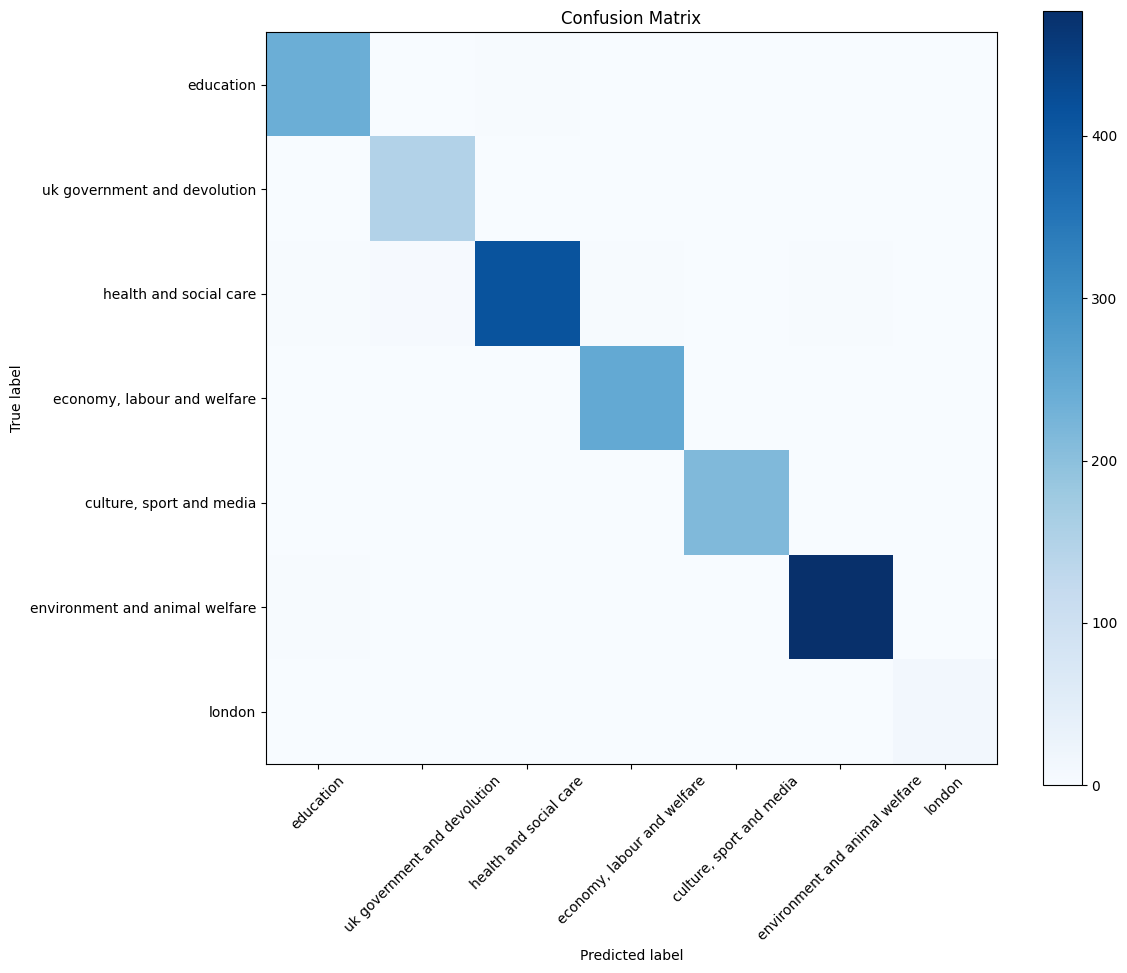

In [22]:
# Confusion Matrix
cm = confusion_matrix(true_labels, final_preds)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_map))
plt.xticks(tick_marks, label_map.keys(), rotation=45)
plt.yticks(tick_marks, label_map.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [23]:
# Check if client's requirements were met

test_accuracy = round(accuracy_score(true_labels, final_preds), 2)

# Check if test accuracy >= 0.86 (Criterion 1)
if test_accuracy >= 0.86:
    print("Success criterion 1 (test accuracy ≥ 86%) is met.")
else:
    print("Success criterion 1 is NOT met.")

Success criterion 1 (test accuracy ≥ 86%) is met.


In [24]:
# Check for overfitting (Criterion 2)
if train_acc - val_accuracy > 0.1:
  print("Warning: Possible overfitting detected! 🚨")
else:
  print("No signs of overfitting. ✅")

No signs of overfitting. ✅


In [25]:
# Check success criteria 3
class_names = list(label_map.keys())
uk_gov_index = class_names.index('uk government and devolution')

# Calculate class-specific misclassification rates
misclassification_rates = []
for i in range(cm.shape[0]):  # Iterate based on the confusion matrix size
    class_total = sum(1 for label in true_labels if label == unique_labels[i])
    class_correct = cm[i,i]
    class_incorrect = class_total - class_correct

    # Avoid division by zero error if class_total is 0
    if class_total == 0:
      misclassification_rates.append(0)
    else:
      misclassification_rates.append(class_incorrect/class_total)

# Check criteria - using the number of unique labels
successful_classes = sum(rate <= 0.13 for rate in misclassification_rates)
if successful_classes >= 5:
    print("Success criterion 3 is met.")
else:
    print("Success criterion 3 is NOT met.")

print(f'Classes meeting ≤13% misclassification: {successful_classes}/7 required')

# Check success criteria 4
uk_gov_index = unique_labels.index(label_map['uk government and devolution'])
uk_gov_rate = misclassification_rates[uk_gov_index]
print(f'UK Government misclassification ≤9%: {"Success criterion 4 is met✅" if uk_gov_rate <= 0.09 else "Success criterion 4 is not met❌"} ({uk_gov_rate:.2%})')

Success criterion 3 is met.
Classes meeting ≤13% misclassification: 7/7 required
UK Government misclassification ≤9%: Success criterion 4 is met✅ (0.00%)
